# Selection of ε-values
1. overview of the distribution over each outcome
2. select relevant range for each objective (a range closer to top/bottom if max/min objective) *
3. divide the selected range by 10 to settle on the ε-value for each objective (by checking what step-size would be useful to distinguish them)
4. redo this process for the other two models as well

\* Reasoning behind (2):
The used data stems from open exploration (i.e., no bias towards good policies). During optimization, we can expect more policies leading to outcomes in the desired ranges. Picking epsilon ranges that are small enough for these ranges makes it more likely that the resolution is high enough (i.e., that the number of pareto-optimal policies chosen is sufficiently high).

## DEFFUANT

In [1]:
from ema_workbench.analysis import parcoords
import pandas as pd
from ema_workbench import load_results
import seaborn as sns
import os
import matplotlib.pyplot as plt
from dmdu.utils_dmdu import epsilon_helper
from model.enums import Metrics

sns.set(rc={'figure.figsize': (30, 14)})

In [2]:
# Get deffuant data
target_dir = os.path.join(os.getcwd(), 'data', 'open_exploration_50_policies_DEFFUANT')
results = load_results(target_dir)
exp, out = results


In [3]:
# # Overview: 1 Parallel axis plot
# out = pd.DataFrame(out)
# limits = parcoords.get_limits(out)
# axes = parcoords.ParallelAxes(limits)
#
# minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
# for metric in minimize:
#     axes.invert_axis(metric)
#
# axes.plot(out)

# Violin-plots for each outcome (subplot 1x5)

# Select a range for each outcome

Colored by model (i.e., belief update function):

## Set limits to be comparable across Belief Update functions

In [4]:
# Load data
deffuant_dir = os.path.join(os.getcwd(), 'data', 'open_exploration_50_policies_DEFFUANT')
sample_dir = os.path.join(os.getcwd(), 'data', 'open_exploration_50_policies_SAMPLE')
sit_dir = os.path.join(os.getcwd(), 'data', 'open_exploration_50_policies_SIT')

_, deffuant_out = load_results(deffuant_dir)
_, sample_out = load_results(sample_dir)
_, sit_out = load_results(sit_dir)

deffuant_out = pd.DataFrame(deffuant_out)
sample_out = pd.DataFrame(sample_out)
sit_out = pd.DataFrame(sit_out)

# Add a column specifying the belief_update_fn that the data stems from
deffuant_out['belief_update_fn'] = 'deffuant'
sample_out['belief_update_fn'] = 'sample'
sit_out['belief_update_fn'] = 'sit'

# Concatinate data & get overall limits
out = pd.concat([deffuant_out, sample_out, sit_out])
limits = parcoords.get_limits(out)

In [5]:
# Assign each unique policy a color
unique_bufns = out['belief_update_fn'].unique().tolist()
bufn_colors = {}
for _, (bufn, color) in enumerate(zip(unique_bufns, sns.color_palette())):
    bufn_colors[bufn] = color

In [6]:
# axes = parcoords.ParallelAxes(limits)
#
# minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
# for metric in minimize:
#     axes.invert_axis(metric)
#
# # All off policy, colored by BeliefUpdateFn
# for bufn, color in bufn_colors.items():
#     part = out[out["belief_update_fn"] == bufn]
#     axes.plot(part, color=color, label=bufn)
#
# axes.legend()



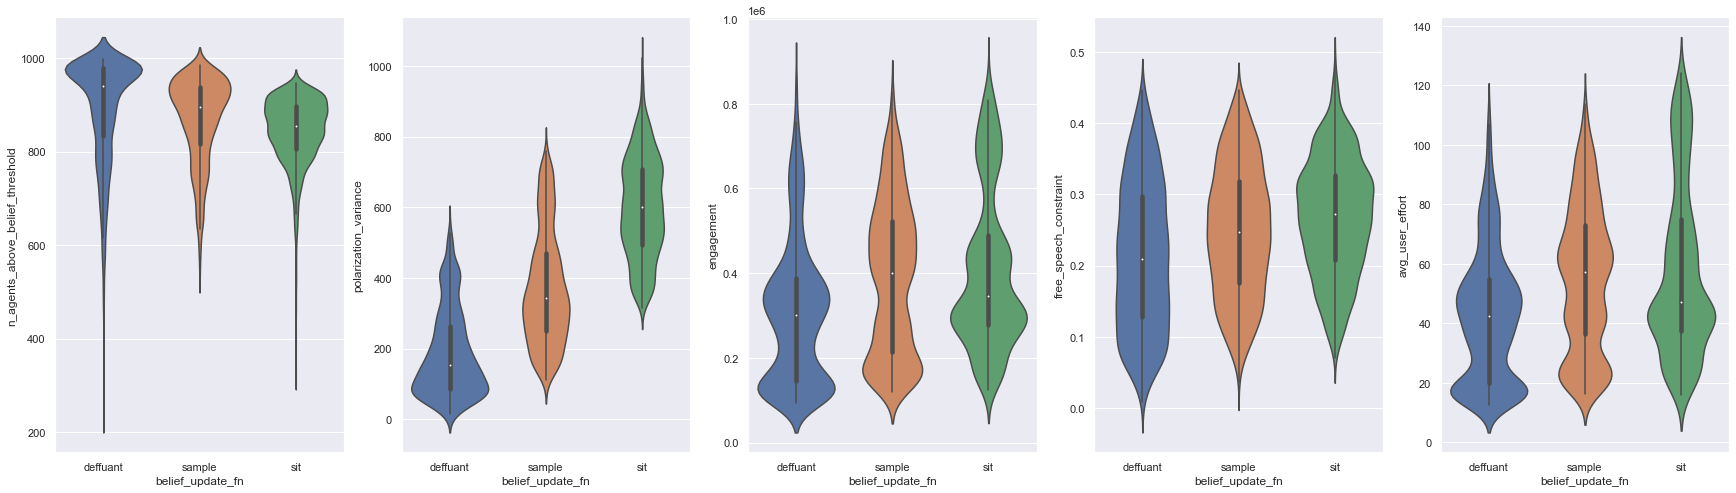

In [7]:
metrics = [m for m in out.columns if m != 'belief_update_fn']

fig, axes = plt.subplots(ncols=len(metrics), figsize=(30, 8))

for i, metric in enumerate(metrics):
    # Plot 1 violin subplot
    sns.violinplot(ax= axes[i], x='belief_update_fn', y=metric, data=out)

In [8]:
out.describe()

,n_agents_above_belief_threshold,polarization_variance,engagement,free_speech_constraint,avg_user_effort
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,867.846133,386.883524,366753.495333,0.243379,51.798828
std,95.278580,219.956569,182675.269481,0.095268,26.067284
min,246.000000,14.090000,94279.000000,0.008783,12.500000
25%,812.000000,196.780000,219546.750000,0.168934,30.045000
50%,886.000000,370.440000,333858.000000,0.246360,47.130000
75%,940.000000,559.640000,480615.750000,0.316482,68.050000
max,998.000000,1022.300000,880185.000000,0.486595,124.170000


In [9]:
out.quantile()

n_agents_above_belief_threshold       886.00000
polarization_variance                 370.44000
engagement                         333858.00000
free_speech_constraint                  0.24636
avg_user_effort                        47.13000
Name: 0.5, dtype: float64

# ––– Exploring the gathered data to pick suitable ε-values –––

In [10]:
# Data structure for saving all epsilon values
deffuant_epsilons = {}
sample_epsilons = {}
sit_epsilons = {}

# 1. Deffuant
### a) n_agents_above_belief_threshold: ε = 1

In [11]:
bufn = 'deffuant'

In [12]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='n_agents_above_belief_threshold',
                                 best_quantile=0.25,
                                 divide_by=10)
print(f'epsilon: {epsilon}')
subset

epsilon: 2.0


125     998
175     998
185     997
225     998
325     998
375     998
385     997
425     996
475     997
575     997
625     998
635     997
675     998
685     997
725     996
775     998
785     997
825     998
875     996
1075    998
1125    997
1175    997
1375    996
1385    996
1575    996
1625    996
1675    998
1725    998
1735    996
1775    996
1875    998
1925    998
1975    998
1985    997
2025    998
2035    997
2175    998
2185    997
2225    998
2235    997
2375    997
2385    996
Name: n_agents_above_belief_threshold, dtype: int64

In [13]:
# Saving epsilon value
deffuant_epsilons[Metrics.N_AGENTS_ABOVE_BELIEF_THRESHOLD] = 1.0

### b) polarization_variance: ε = 0.5

In [14]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='polarization_variance',
                                 best_quantile=0.25,
                                 divide_by=50)
print(f'epsilon: {epsilon}')
subset

epsilon: 2.0189000000000004


225     14.70
375     14.09
675     14.23
1175    16.00
1875    14.99
1925    14.99
1975    15.04
2175    15.10
2225    15.92
Name: polarization_variance, dtype: float64

In [15]:
# Saving epsilon value
deffuant_epsilons[Metrics.POLARIZATION_VARIANCE] = 0.5

### c) engagement: ε = 10,000

In [16]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='engagement',
                                 best_quantile=0.25,
                                 divide_by=10)
print(f'epsilon: {epsilon}')
subset

epsilon: 48493.675


232     874322
382     830936
682     831738
1182    844387
1382    862697
1882    849204
1932    849204
1982    846103
2382    830120
Name: engagement, dtype: int64

In [17]:
deffuant_epsilons[Metrics.ENGAGEMENT] = 10000

### d) free_speech_constraint: ε = 0.01

In [18]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='free_speech_constraint',
                                 best_quantile=0.25,
                                 divide_by=10)
print(f'epsilon: {epsilon}')
subset

epsilon: 0.013589917015465396


75      0.016733
525     0.020954
975     0.010762
985     0.016696
1269    0.022234
1272    0.020954
1275    0.008783
1285    0.013231
1298    0.020262
2275    0.018109
Name: free_speech_constraint, dtype: float64

In [19]:
deffuant_epsilons[Metrics.FREE_SPEECH_CONSTRAINT] = 0.01


### e) avg_user_effort: ε = 0.5

In [20]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='avg_user_effort',
                                 best_quantile=0.25,
                                 divide_by=50)
print(f'epsilon: {epsilon}')
subset

epsilon: 0.64935


66      12.64
516     12.68
916     12.55
966     12.50
1266    12.86
1616    13.05
2116    13.07
2266    13.03
2416    13.08
Name: avg_user_effort, dtype: float64

In [21]:
deffuant_epsilons[Metrics.AVG_USER_EFFORT] = 0.5

# Epsilon-values

In [22]:
for bufn, v in deffuant_epsilons.items():
    print(f'{v}: \t {bufn.name}')

1.0: 	 N_AGENTS_ABOVE_BELIEF_THRESHOLD
0.5: 	 POLARIZATION_VARIANCE
10000: 	 ENGAGEMENT
0.01: 	 FREE_SPEECH_CONSTRAINT
0.5: 	 AVG_USER_EFFORT


# 2. Sample
### a) n_agents_above_belief_threshold: ε = 1

In [23]:
bufn = 'sample'

In [24]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='n_agents_above_belief_threshold',
                                 best_quantile=0.25,
                                 divide_by=10)
print(f'epsilon: {epsilon}')
subset

epsilon: 4.6


260     981
342     982
424     983
446     981
460     981
660     982
696     982
846     981
1460    981
1574    981
1610    981
1624    983
1660    982
1724    981
1760    982
2410    982
2424    985
Name: n_agents_above_belief_threshold, dtype: int64

In [25]:
# Saving epsilon value
sample_epsilons[Metrics.N_AGENTS_ABOVE_BELIEF_THRESHOLD] = 1.0

### b) polarization_variance: ε = 1.0

In [26]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='polarization_variance',
                                 best_quantile=0.25,
                                 divide_by=20)
print(f'epsilon: {epsilon}')
subset

epsilon: 18.04575


324     126.13
342     111.19
424     120.77
446     116.59
474     126.73
660     123.60
696     113.58
742     117.28
846     121.32
874     124.43
1110    126.68
1524    127.82
1546    125.04
1610    127.49
1624    119.93
1660    121.83
1910    126.68
1992    117.28
2424    113.64
Name: polarization_variance, dtype: float64

In [27]:
# Saving epsilon value
sample_epsilons[Metrics.POLARIZATION_VARIANCE] = 1.0

### c) engagement: ε = 10,000

In [28]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='engagement',
                                 best_quantile=0.25,
                                 divide_by=10)
print(f'epsilon: {epsilon}')
subset

epsilon: 30421.3


260     810248
410     818461
460     803864
710     806396
760     799444
860     826357
910     828109
1010    828109
1460    810248
1610    802474
1660    815093
1760    816866
1960    806396
Name: engagement, dtype: int64

### d) free_speech_constraint: ε = 0.01

In [29]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='free_speech_constraint',
                                 best_quantile=0.25,
                                 divide_by=5)
print(f'epsilon: {epsilon}')
subset

epsilon: 0.042148529956146645


10      0.074111
16      0.066485
17      0.058675
26      0.075798
34      0.077189
42      0.065006
46      0.057471
216     0.076750
246     0.077129
517     0.070664
542     0.071535
546     0.062406
616     0.075611
646     0.066914
1050    0.075466
1057    0.073223
1058    0.068589
1059    0.059888
1060    0.058167
1061    0.074409
1066    0.046809
1067    0.035180
1075    0.070869
1076    0.060121
1077    0.073615
1081    0.058100
1082    0.072268
1084    0.058192
1086    0.076971
1087    0.069682
1090    0.062132
1092    0.043459
1094    0.070038
1096    0.043242
2160    0.076726
2167    0.068540
2192    0.069999
2196    0.059212
Name: free_speech_constraint, dtype: float64

### e) avg_user_effort: ε = 0.5


In [30]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='avg_user_effort',
                                 best_quantile=0.25,
                                 divide_by=50)
print(f'epsilon: {epsilon}')
subset

epsilon: 1.0488499999999998


312     16.31
412     16.86
562     17.09
712     16.06
862     16.76
1512    16.66
1562    16.69
1712    16.69
1962    16.06
2062    16.90
2262    16.53
2362    16.53
Name: avg_user_effort, dtype: float64

# 3. Social Impact Theory (SIT)
### a) n_above_belief_threshold: ε = 1

In [31]:
bufn = 'sit'

In [32]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='n_agents_above_belief_threshold',
                                 best_quantile=0.25,
                                 divide_by=10)
print(f'epsilon: {epsilon}')
subset

epsilon: 4.8


127     942
377     946
577     942
1027    944
1177    942
1677    942
1827    944
1977    942
2477    945
Name: n_agents_above_belief_threshold, dtype: int64

In [33]:
# Saving epsilon value
sit_epsilons[Metrics.N_AGENTS_ABOVE_BELIEF_THRESHOLD] = 1.0

### b) polarization_variance: ε = 1.0

In [34]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='polarization_variance',
                                 best_quantile=0.25,
                                 divide_by=50)
print(f'epsilon: {epsilon}')
subset

epsilon: 16.18


127     328.57
314     329.92
327     328.79
377     315.43
577     322.95
727     328.15
1027    314.45
1177    328.95
1677    329.05
1827    317.43
1977    324.63
2327    327.66
2477    319.50
Name: polarization_variance, dtype: float64

In [35]:
# Saving epsilon value
sit_epsilons[Metrics.POLARIZATION_VARIANCE] = 1.0

### c) engagement: ε = 10,000


In [36]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='engagement',
                                 best_quantile=0.25,
                                 divide_by=10)
print(f'epsilon: {epsilon}')
subset

epsilon: 38981.175


523     872966
545     880185
2395    850719
Name: engagement, dtype: int64

### d) free_speech_constraint: ε = 0.01

In [37]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='free_speech_constraint',
                                 best_quantile=0.25,
                                 divide_by=10)
print(f'epsilon: {epsilon}')
subset

epsilon: 0.027758578967182812


505     0.085735
507     0.069462
509     0.078227
512     0.075012
514     0.073498
515     0.095069
517     0.084327
518     0.083608
521     0.097056
524     0.086643
525     0.096008
527     0.075416
531     0.096089
532     0.091155
534     0.087894
536     0.080702
540     0.087711
547     0.082160
548     0.094525
664     0.091242
677     0.092460
2264    0.094078
2277    0.095123
2355    0.095716
2357    0.081713
2362    0.095889
2364    0.083094
2367    0.097072
2374    0.097061
2377    0.089460
2386    0.095693
2397    0.094873
Name: free_speech_constraint, dtype: float64

### e) avg_user_effort: ε = 0.5

In [38]:
subset, epsilon = epsilon_helper(outcomes=out,
                                 bufn=bufn,
                                 metric='avg_user_effort',
                                 best_quantile=0.25,
                                 divide_by=50)
print(f'epsilon: {epsilon}')
subset

epsilon: 1.06495


9       15.90
59      16.16
109     16.59
159     16.01
209     16.43
259     16.61
309     16.33
409     15.88
459     16.27
609     16.05
759     16.28
859     16.05
909     16.32
959     16.12
1059    16.05
1109    16.44
1159    16.69
1259    16.81
1359    16.05
1409    15.91
1459    16.28
1509    15.91
1559    15.91
1659    16.19
1759    16.44
1909    16.26
2009    15.99
2059    16.20
2109    15.88
2209    15.99
2309    16.78
Name: avg_user_effort, dtype: float64

In [39]:
# TODO: add remaining epsilon values to the dictionaries
# TODO: print dicts, compare values, settle on final epsilons (shared across models)

In [42]:
print(f'deffuant:')
for bufn, v in deffuant_epsilons.items():
    print(f'{v}: \t {bufn.name}')

print(f'\n\nsample:')
for bufn, v in sample_epsilons.items():
    print(f'{v}: \t {bufn.name}')

print(f'\n\nsit:')
for bufn, v in sit_epsilons.items():
    print(f'{v}: \t {bufn.name}')


deffuant:
1.0: 	 N_AGENTS_ABOVE_BELIEF_THRESHOLD
0.5: 	 POLARIZATION_VARIANCE
10000: 	 ENGAGEMENT
0.01: 	 FREE_SPEECH_CONSTRAINT
0.5: 	 AVG_USER_EFFORT


sample:
1.0: 	 N_AGENTS_ABOVE_BELIEF_THRESHOLD
1.0: 	 POLARIZATION_VARIANCE


sit:
1.0: 	 N_AGENTS_ABOVE_BELIEF_THRESHOLD
1.0: 	 POLARIZATION_VARIANCE


### Note:
The engagement metric was adjusted after this. Instead of being the **TOTAL** amount of seen posts over all agents (over the complete run), it is now the average **PER AGENT**.
Thus, with the used n_agents of 1000, the epsilon value is adjusted from 10,000 to 10.

# Epsilon Values
- 1 – N_AGENTS_ABOVE_BELIEF_THRESHOLD
- 1.0 – POLARIZATION_VARIANCE
- 10 – ENGAGEMENT (now per agent, thus: 10k -> 10)
- 0.01 – FREE_SPEECH_CONSTRAINT
- 0.5 – AVG_USER_EFFORT

In [6]:
import random
seeds = [random.randint(100000, 999999) for i in range(100)]
print(seeds)

[577747, 914425, 445063, 977049, 617127, 639676, 137294, 845058, 718814, 119679, 435223, 347541, 666852, 701324, 604437, 908374, 941595, 800210, 745388, 399447, 140918, 910967, 917428, 497096, 222919, 726572, 748497, 185669, 610661, 709441, 801330, 506120, 891889, 298223, 164318, 929955, 854094, 553307, 279254, 597549, 223105, 708080, 220244, 126086, 634792, 458729, 822070, 972244, 751076, 130675, 100289, 252061, 262114, 449996, 206219, 764775, 285626, 385767, 111989, 812234, 305433, 822474, 312966, 877990, 598853, 389796, 777981, 937667, 943990, 393412, 913947, 594493, 543410, 199872, 519301, 577412, 615253, 914266, 136560, 705707, 433804, 414487, 198043, 325188, 906659, 507433, 268008, 894819, 994630, 427593, 129353, 207160, 780566, 131963, 158586, 428856, 485180, 445734, 806806, 958623]


In [7]:
[1, 2, 3] + [4, 5]

[1, 2, 3, 4, 5]